In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import random
from bs4 import BeautifulSoup
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from scipy.sparse import hstack
from tqdm import tqdm

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [3]:
train_df = pd.read_csv('train.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test_df = pd.read_csv('test.csv')
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


**Columns**

**id** - a unique identifier for each tweet

**text** - the text of the tweet

**location** - the location the tweet was sent from (may be blank)

**keyword** - a particular keyword from the tweet (may be blank)

**target** - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [5]:
print('Shape of the train dataset',train_df.shape)
print('Shape of the test dataset',test_df.shape)

Shape of the train dataset (7613, 5)
Shape of the test dataset (3263, 4)


# **Exploratory Data Analysis**

### **Distribution of class labels of the training dataset**

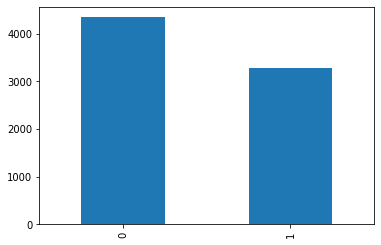

In [6]:
train_df['target'].value_counts().plot(kind='bar')
plt.show()

* **The bar plot demonstrates that we have a reasonable amount of data from both classes, indicating that we won't have any problems with data imbalance.**

### **Checking For Nan Value Along the columns in tha dataframe**

In [7]:
train_df.isna().sum(axis=0)

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

* **In this project we are just going to use only text feature for modeling**

### **Data Cleaning**

#### **Deduplication of tweets**

In [8]:
train_df.text[train_df.text.duplicated()]

48      Check these out: http://t.co/rOI2NSmEJJ http:/...
115     320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...
119     320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...
164     Experts in France begin examining airplane deb...
624                            To fight bioterrorism sir.
                              ...                        
7600    Evacuation order lifted for town of Roosevelt:...
7607    #stormchase Violent Record Breaking EF-5 El Re...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
Name: text, Length: 110, dtype: object

* **We discovered 110 duplicate tweets; we are keeping only one instance of the tweet and deleting the rest.**

In [9]:
train_df.text.drop_duplicates(keep='first', inplace=True)

### **Text Preprocessing**

In [10]:
#printing some random tweets
for i in range(1,6):
    tweet_no = random.randint(0,train_df.shape[0])
    print(train_df.text.loc[tweet_no])

Photo: forrestmankins: Colorado camping. http://t.co/S0VgTkhW7V
@Eganator2000 There aren't many Obliteration servers but I always like to play when there are :D
Fukushima Nuclear Disaster | Increased Thyroid Cancer in U.S. http://t.co/FtuNlH6ddg
'Bloody 'ell! Let it burn!' #RubyBot
WFTV Eyewitness News: TN school psychologist arrested in Florida on child porn charges http://t.co/lgGLf5yrMe


* **We can see that most tweets have hyperlinks, hashtags(#), tags(@), stock market stickers like $GT, old style retweet text RT, and certain signs like..., etc. by running the above code for multiples. We will remove all of this unnecessary content.**

In [11]:
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [12]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [13]:
def pre_process_text_data(df, column_name='text'):
    
    pre_processed_tweets = []
    for tweet in df[column_name].values:
         tweet = ' '.join(t.lower() for t in tweet.split() if t.lower() not in stop_words)
         # remove hyperlinks
         tweet = re.sub(r"http\S+", "", tweet)
         tweet = BeautifulSoup(tweet, 'lxml').get_text()
         tweet = decontracted(tweet)
         # remove words with numbers
         tweet = re.sub("\S*\d\S*", "", tweet).strip()
         # remove spacial character
         tweet = re.sub('[^A-Za-z]+', ' ', tweet)
         # remove stock market tickers like $GE
         tweet = re.sub(r'\$\w*', '', tweet)
         # remove old style retweet text "RT"
         tweet = re.sub(r'^RT[\s]+', '', tweet)
         # remove hashtag  @, ... sign from the word
         tweet = re.sub(r'\.{3}|@|#|û_', '', tweet)
         # tokenize tweets
         tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
         tweet_tokens = tokenizer.tokenize(tweet)
         cleaned_token = []
         for token in tweet_tokens:
                if  len(token) > 2:
                 lemma_word = lemmatizer.lemmatize(token) 
                 cleaned_token.append(token)
         tweet = ' '.join(cleaned_token)
         pre_processed_tweets.append(tweet)
    return pre_processed_tweets

In [14]:
pre_processed_tweets = pre_process_text_data(train_df, column_name='text')

In [93]:
pre_processed_tweets_test = pre_process_text_data(test_df, column_name='text')

In [15]:
pre_processed_tweets[:5]

['deeds reason earthquake may allah forgive',
 'forest fire near ronge sask canada',
 'residents asked ishelter place notified officers evacuation shelter place orders expected',
 'people receive wildfires evacuation orders california',
 'got sent photo ruby alaska smoke wildfires pours school']

#### **New DataFrame Was Created with Preprocessed Tweets and Target Label**

In [16]:
new_df = pd.DataFrame(
                        data = {
                            'tweets':pre_processed_tweets,
                            'target':train_df.target.values
                        },
                        columns = ['tweets', 'target']
                     )

print('Shape of the dataframe:',new_df.shape)
new_df.head()

Shape of the dataframe: (7613, 2)


,tweets,target
0,deeds reason earthquake may allah forgive,1
1,forest fire near ronge sask canada,1
2,residents asked ishelter place notified office...,1
3,people receive wildfires evacuation orders cal...,1
4,got sent photo ruby alaska smoke wildfires pou...,1


In [17]:
new_df.to_csv('pre_processed_tweets.csv',index=False)

In [18]:
X = new_df.tweets.copy()
y = new_df.target.copy()

# **Train Test Validation Split**

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

# **Featurization**

### **Bag of Words**

In [20]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_train)
print("some feature names ", count_vect.get_feature_names_out()[:10])
print('='*50)

X_train_bow = count_vect.transform(X_train)
print("the type of count vectorizer ",type(X_train_bow))
print("the shape of out text BOW vectorizer ",X_train_bow.get_shape())
print("the number of unique words ", X_train_bow.get_shape()[1])

some feature names  ['aaa' 'aaalll' 'aaand' 'aaarrrgghhh' 'aace' 'aan' 'aannnd' 'aar'
 'aaronthefm' 'aashiqui']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (6471, 14015)
the number of unique words  14015


In [21]:
X_val_bow = count_vect.transform(X_val)
print("the shape of out text BOW vectorizer ", X_val_bow.get_shape())

the shape of out text BOW vectorizer  (1142, 14015)


### **Bi-Grams and n-Grams**

In [124]:
count_vect_grams = CountVectorizer(ngram_range=(1,3), min_df=1)
X_train_bow_bigram = count_vect_grams.fit_transform(X_train)
print("the type of count vectorizer ",type(X_train_bow_bigram))
print("the shape of out text BOW vectorizer ",X_train_bow_bigram.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_train_bow_bigram.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (6471, 89484)
the number of unique words including both unigrams and bigrams  89484


In [95]:
X_val_bow_bigram = count_vect_grams.transform(X_val)
print("the shape of out text BOW vectorizer ", X_val_bow_bigram.get_shape())

the shape of out text BOW vectorizer  (1142, 89484)


### **TF-IDF With Bigrams**

In [125]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
tf_idf_vect.fit(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names_out()[0:10])
print('='*50)

X_train_tfidf = tf_idf_vect.transform(X_train)
print("the type of count vectorizer ",type(X_train_tfidf))
print("the shape of out text TFIDF vectorizer ",X_train_tfidf.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_train_tfidf.get_shape()[1])

some sample features(unique words in the corpus) ['aaa' 'aaa lemme' 'aaalll' 'aaalll even' 'aaand' 'aaand there'
 'aaarrrgghhh' 'aace' 'aace org' 'aan']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (6471, 52939)
the number of unique words including both unigrams and bigrams  52939


In [126]:
X_val_tfidf = tf_idf_vect.transform(X_val)
print("the shape of out text TFIDF vectorizer ", X_val_tfidf.get_shape())

the shape of out text TFIDF vectorizer  (1142, 52939)


### **W2v : Googel Pre-Trained Model**

In [26]:
#!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

#!7za e ./GoogleNews-vectors-negative300.bin.gz

In [27]:
from gensim.models import KeyedVectors
    
w2v_model=KeyedVectors.load_word2vec_format('/content/drive/MyDrive/GoogleNews-vectors-negative300.bin', binary=True)

In [28]:
w2v_words = list(w2v_model.vocab)
print("sample words ", w2v_words[0:50])

sample words  ['</s>', 'in', 'for', 'that', 'is', 'on', '##', 'The', 'with', 'said', 'was', 'the', 'at', 'not', 'as', 'it', 'be', 'from', 'by', 'are', 'I', 'have', 'he', 'will', 'has', '####', 'his', 'an', 'this', 'or', 'their', 'who', 'they', 'but', '$', 'had', 'year', 'were', 'we', 'more', '###', 'up', 'been', 'you', 'its', 'one', 'about', 'would', 'which', 'out']


### **TFIDF weighted W2v**

In [ ]:
model = TfidfVectorizer()
model.fit(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names_out(), list(model.idf_)))

In [30]:
# TF-IDF weighted Word2Vec

def tf_idf_weighted_w2v(df):

  tfidf_feat = model.get_feature_names_out()

  tfidf_sent_vectors = []
  row=0
  for sent in tqdm(df):
    sent_vec = np.zeros(50) 
    weight_sum =0
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

  return tfidf_sent_vectors

In [31]:
tfidf_sent_vectors_train =  tf_idf_weighted_w2v(X_train)

100%|██████████| 6471/6471 [2:22:12<00:00,  1.32s/it]


In [32]:
tfidf_sent_vectors_val = tf_idf_weighted_w2v(X_val)

100%|██████████| 1142/1142 [25:01<00:00,  1.31s/it]


**Modeling**

In [49]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

**MultinomialNB: Bag Of Words**

In [87]:
params = {
          'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]
         }

In [35]:
clf = MultinomialNB()
grid = GridSearchCV(clf, param_grid=params, n_jobs=-1, cv=5, verbose=5)
grid.fit(X_train_bow, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]}, verbose=5)

In [36]:
grid.best_params_

{'alpha': 10.0}

In [89]:
clf = MultinomialNB(alpha=10).fit(X_train_bow,y_train)
pred = clf.predict(X_val_bow)

print(classification_report(pred,y_val))

              precision    recall  f1-score   support

           0       0.90      0.81      0.85       726
           1       0.71      0.84      0.77       416

    accuracy                           0.82      1142
   macro avg       0.81      0.82      0.81      1142
weighted avg       0.83      0.82      0.82      1142



**MultinomialNB: BOW BI-GRAMS**

In [99]:
clf = MultinomialNB(alpha=10).fit(X_train_bow_bigram,y_train)
pred = clf.predict(X_val_bow_bigram)

print(classification_report(pred,y_val))

              precision    recall  f1-score   support

           0       0.91      0.80      0.85       734
           1       0.71      0.85      0.77       408

    accuracy                           0.82      1142
   macro avg       0.81      0.83      0.81      1142
weighted avg       0.83      0.82      0.82      1142



**MultinomialNB: TF-IDF**

In [90]:
grid = GridSearchCV(clf, param_grid=params, n_jobs=-1, cv=5, verbose=5)
grid.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5, estimator=MultinomialNB(alpha=10), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]}, verbose=5)

In [91]:
grid.best_params_

{'alpha': 0.5}

In [92]:
clf = MultinomialNB(alpha=0.5).fit(X_train_tfidf,y_train)
pred = clf.predict(X_val_tfidf)

print(classification_report(pred,y_val))

              precision    recall  f1-score   support

           0       0.92      0.79      0.85       757
           1       0.68      0.87      0.76       385

    accuracy                           0.82      1142
   macro avg       0.80      0.83      0.81      1142
weighted avg       0.84      0.82      0.82      1142



**MultinomialNB: TF-IDF W2V**

In [42]:
grid = GridSearchCV(clf, param_grid=params, n_jobs=-1, cv=5, verbose=5)
grid.fit(tfidf_sent_vectors_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5, estimator=MultinomialNB(alpha=1), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]}, verbose=5)

In [44]:
clf = MultinomialNB(alpha=0.01).fit(tfidf_sent_vectors_train,y_train)
pred = clf.predict(tfidf_sent_vectors_val)

print(classification_report(pred,y_val))

              precision    recall  f1-score   support

           0       1.00      0.57      0.73      1142
           1       0.00      0.00      0.00         0

    accuracy                           0.57      1142
   macro avg       0.50      0.29      0.36      1142
weighted avg       1.00      0.57      0.73      1142



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**XGBOOST TF-IDF BIGRAM**

In [47]:
import xgboost as xgb

params = {
        'learning_rate':[0.001,0.01],
        'colsample_bytree':[0.7,1],
        'subsample':[0.7,1],
          }
        
clf = xgb.XGBClassifier()          
grid = GridSearchCV(clf,params,cv=3,scoring='accuracy',return_train_score=True,verbose=2,n_jobs=-1)
grid.fit(X_train_tfidf, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3, estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 1],
                         'learning_rate': [0.001, 0.01],
                         'subsample': [0.7, 1]},
             return_train_score=True, scoring='accuracy', verbose=2)

In [50]:
grid.best_params_

{'colsample_bytree': 0.7, 'learning_rate': 0.01, 'subsample': 1}

In [51]:
grid.best_score_

0.6396229330860764